# UYDU GÖRÜNTÜLERİNDEN GEMİ TESPİTİ

Amaç yapay sinir ağı kullanarak uydu görüntülerinden gemi tespiti çalışmasıdır.

![title](images/ship.jpg)

## VERİ SETİ HAKKINDA BİLGİ

Veri seti olarak Kaggle sitesinde <a href="https://www.kaggle.com/rhammell/ships-in-satellite-imagery">yayınlanan</a> <b>Classify ships in San Franciso Bay using Planet satellite imagery</b> <i style="color:#777;">(Planet uydu görüntülerini kullanarak San Francisco Körfezi'ndeki gemileri sınıflandırın)</i> veri seti kullanılmıştır.

* Veri seti, California'nın San Francisco Körfezi ve San Pedro Körfezi bölgeleri üzerinde toplanan Planet uydu görüntülerini içermektedir.

* Toplam 4000 adet uydu görüntüsünden oluşmaktadır.

* Uydu görüntüleri, **1** veya **0** değerinde **"gemi"** veya **"gemi yok"** sınıflandırmasıyla etiketlenmiş  80x80 boyutunda ve 3 kanal (RGB) içerir.

* Uydu görüntüleri **.png** uzantısında ve belirli bir dosya adı formatındadır.

* Uydu görüntüsü adı formatı : {etiket} __ {sahne kimliği} __ {boylam} _ {enlem}.png

### KÜTÜPHANELERİN YÜKLENMESİ

In [1]:
# TEMEL KÜTÜPHANELER
# dizi/matris kütüphanesi
import numpy as np
# veri analizi kütüphanesi
import pandas as pd
# veri görselleştirme kütüphanesi
import matplotlib.pyplot as plt
# veri görselleştirme kütüphanesi
import seaborn as sns
# json modülü
import json
# dosya işlemleri modülü
import os
# dosya listeleme modülü
import glob
# imge kütüphanesi
from PIL import Image, ImageDraw
# zaman modülü
import time
# opencv kütüphanesi
import cv2, os, re
# uyarıları kaldırma modülü
import warnings
warnings.filterwarnings('ignore')


# KERAS KÜTÜPHANESİ
# scikit-learn veri seti bölme modülü
from sklearn.model_selection import train_test_split
# keras katman modülü
from keras.models import Sequential
# keras bağlama, düzleştirme, aktivasyon fonksiyonları,  modülü
from keras.layers import Dense, Flatten, Activation, Dropout
# keras evrişim ve boyut azaltma modülü
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils, to_categorical
# keras optimizasyon modülü
from keras.optimizers import Adam, SGD
# karışıklık matrisi
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import imutils
# maksimum olmayan bastırma
from imutils.object_detection import non_max_suppression
# model yükleme
from keras.models import load_model
# model kaydetme
from keras.models import save_model

## VERİ SETİNİN YÜKLENMESİ

In [2]:
with open('shipsnet.json') as data_file:
    # dosyaya erişim ve isimlendirme
    dataset = json.load(data_file)

#### Pandas DataFrame'e Çevirme

In [3]:
# pandas DataFrame'e çevirme
df_shipsnet= pd.DataFrame(dataset)
# ilk 5 veriyi gösterme
df_shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


#### Veri Seti Hakkında Bilgi

In [4]:
df_shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


#### Veri Seti Hakkında İstatistiksel Bilgiler

In [5]:
# .T = transpoz
df_shipsnet.describe().T

,count,mean,std,min,25%,50%,75%,max
labels,4000.0,0.25,0.433067,0.0,0.0,0.0,0.25,1.0


In [6]:
# verileri numpy dizisine çevirme
data = np.array(dataset['data']).astype('float32')
data

array([[ 82.,  89.,  91., ...,  86.,  88.,  89.],
       [ 76.,  75.,  67., ...,  54.,  57.,  58.],
       [125., 127., 129., ..., 111., 109., 115.],
       ...,
       [171., 135., 118., ...,  95.,  95.,  85.],
       [ 85.,  90.,  94., ...,  96.,  95.,  89.],
       [122., 122., 126., ...,  51.,  46.,  69.]], dtype=float32)

In [7]:
# veri boyutu
data.shape

(4000, 19200)

In [8]:
# etiketleri numpy dizisine çevirme
# 1 = gemi var
# 0 = gemi yok
label = np.array(dataset['labels']).astype('uint8')
label

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [9]:
# etiket boyutu
label.shape

(4000,)

In [10]:
# etiketleri sınıflandırma
class_names = ["gemi-yok","gemi-var"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'gemi-yok': 0, 'gemi-var': 1}

In [11]:
# sınıf sayısı
num_classes

2

In [12]:
# görüntüler hakkında bilgi fonksiyonu
def info_images(data,label):
    
    """
    Bu fonksiyon veri setindeki görüntü ve etiketler hakkında bilgi verir
    PARAMETRELER 
        data  : verilerin bulunduğu kolon
        label : etiketlerin bulunduğu kolon
    RETURN
        Toplam Görüntü Sayısı = (len(data))
        Gemi İçeren Görüntü Sayısı = np.sum(label == 1)
        % Değeri Olarak Gemi İçeren Görüntü Oranı = 100*np.mean(label)
        Gemi Bulunmayan Görüntü Sayısı = np.sum(label == 0)
    """
    
    print('Toplam Görüntü Sayısı: {}'.format(len(data)))
    print('Gemi İçeren Görüntü Sayısı: {}'.format(np.sum(label == 1)))
    print('Gemi İçeren Görüntüler Oranı: {:.2f}%'.format(100*np.mean(label)))
    print('Gemi İçermeyen Görüntü Sayısı : {}'.format(np.sum(label == 0)))

In [13]:
# görüntüler hakkında bilgi
info_images(data,label)

Toplam Görüntü Sayısı: 4000
Gemi İçeren Görüntü Sayısı: 1000
Gemi İçeren Görüntüler Oranı: 25.00%
Gemi İçermeyen Görüntü Sayısı : 3000


In [14]:
# etiket sayısı
label.shape[0]

4000

In [15]:
n_labels = label.shape[0]
# farklı değerleri bulma
_, count = np.unique(label, return_counts=True)
df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Toplam Sayı','Sınıf Etiketi']
df.set_index('Sınıf Etiketi',inplace=True)
df

,Toplam Sayı
Sınıf Etiketi,
gemi-yok,3000
gemi-var,1000


#### Bar Gösterimi

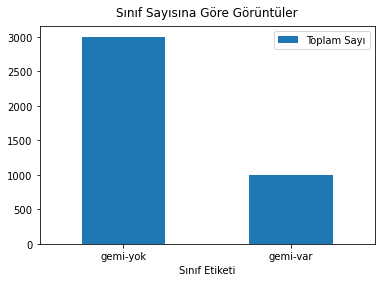

In [16]:
df.plot.bar(rot=0)
# başlık
plt.title("Sınıf Sayısına Göre Görüntüler", pad = 10);

#### Pasta Gösterimi

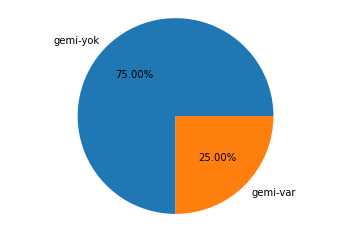

In [17]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

## VERİ ÖN İŞLEME

Veri seti incelendiğinde gemi olmayan görüntülerin gemi olana göre 3 katı olduğu görünmektedir.

Veri setinin dengeli olması için gemi sınıfına ait yeni görüntüler üretilecektir.

In [18]:
# kanal sayısı (RGB)
num_channel = 3
# genişlik
width = 80
# yükseklik
height = 80
# sınıf sayısı
num_classes = 2

In [19]:
# verileri yeniden boyutlandırma (reshape)
data_reshape = data.reshape([-1,3,80,80]).transpose([0,2,3,1])
data_reshape.shape

(4000, 80, 80, 3)

In [20]:
# etiketleri yeniden boyutlandırma (reshape)
label_reshape = to_categorical(label, num_classes)
label_reshape.shape

(4000, 2)

In [21]:
# içerisinde gemi bulunan veriler
ship1 = data_reshape[label==1] 
ship1.shape

(1000, 80, 80, 3)

In [22]:
# içerisinde gemi bulunmayan veriler
ship0 = data_reshape[label==0] 
ship0.shape

(3000, 80, 80, 3)

In [23]:
ship1[0].shape

(80, 80, 3)

## VERİLERİ GÖRSELLEŞTİRME

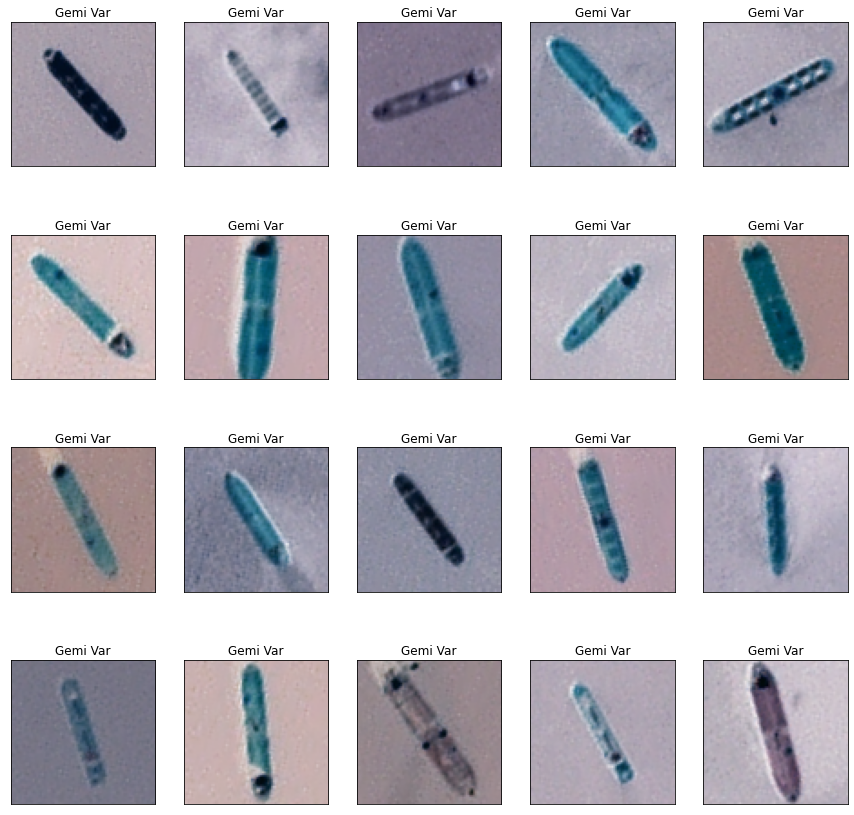

In [24]:
# gemi bulunan 20 veriyi gösterme
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((ship1[i] * 255).astype(np.uint8))
    plt.title('Gemi Var', pad=5)
plt.show()

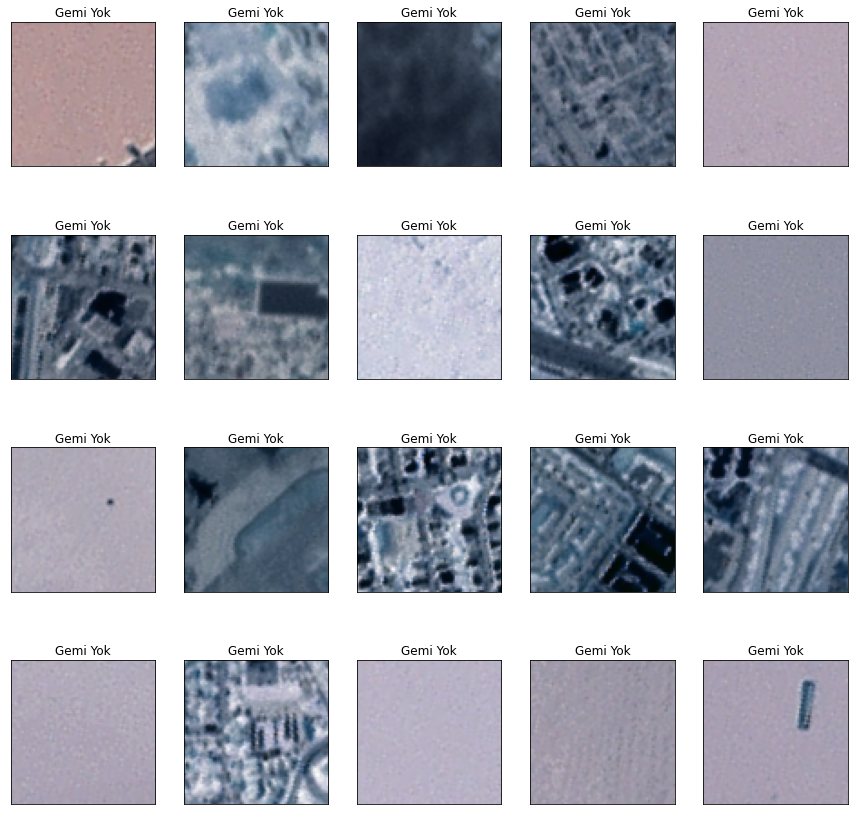

In [25]:
# gemi bulunmayan 20 veriyi gösterme
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((ship0[i] * 255).astype(np.uint8))
    plt.title('Gemi Yok', pad=5)
plt.show()

In [26]:
# verilerin normalize edilmesi
data_reshape_norm = data_reshape / 255.0

In [27]:
data_reshape_norm.shape

(4000, 80, 80, 3)

In [28]:
label_reshape.shape

(4000, 2)

## VERİ SETİNİN EĞİTİM VE TEST OLARAK AYRILMASI

In [29]:
# % 10 test verisi
X_train, X_test, y_train, y_test = train_test_split(data_reshape_norm, label_reshape, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

x_train shape (3600, 80, 80, 3)
x_test shape (400, 80, 80, 3)
y_train shape (3600, 2)
y_test shape (400, 2)


# CNN MODELİ (EVRİŞİMLİ SİNİR AĞI)

In [30]:
# CNN Modeli Yapısı
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',  activation = 'relu', input_shape = (80, 80, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.20))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.20))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.20))

model.add(Conv2D(filters= 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))
# output
model.add(Dense(2, activation='softmax'))  # sigmoid

### Modelin Özeti

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       1

### Model Optimizasyon İşlemi

In [32]:
# Adam ile learning_rate oranı değiştirilir
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

### Modeli Derleme

In [33]:
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [34]:
# eğer 10 resim var ve batch_size=2 belirlendiyse epok=5 olur
epochs = 10 
batch_size = 360

### Modeli Eğitme

In [35]:
history = model.fit(np.array(X_train), np.array(y_train),
                   steps_per_epoch=len(X_train)//batch_size,
                   epochs=epochs,
                   verbose=1
        )

Epoch 1/10
10/10 [==============================] - 1046s 72s/step - loss: 0.5850 - accuracy: 0.7291
Epoch 2/10
10/10 [==============================] - 624s 65s/step - loss: 0.4517 - accuracy: 0.7917
Epoch 3/10
10/10 [==============================] - 342s 36s/step - loss: 0.3548 - accuracy: 0.8586
Epoch 4/10
10/10 [==============================] - 458s 45s/step - loss: 0.2415 - accuracy: 0.8979
Epoch 5/10
10/10 [==============================] - 564s 57s/step - loss: 0.1989 - accuracy: 0.9230
Epoch 6/10
10/10 [==============================] - 554s 58s/step - loss: 0.1705 - accuracy: 0.9356
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.933 - 470s 45s/step - loss: 0.1675 - accuracy: 0.9339
Epoch 8/10
10/10 [==============================] - 436s 45s/step - loss: 0.1474 - accuracy: 0.9452
Epoch 9/10
10/10 [==============================] - 529s 52s/step - loss: 0.1389 - accuracy: 0.9489
Epoch 10/10
10/10 [==============================] - 360

### Modeli Kaydetme

In [36]:
model.save('cnn_model.h5')  # creates a HDF5 file 'my_model.h5'

### Modelin Değerlendirilmesi

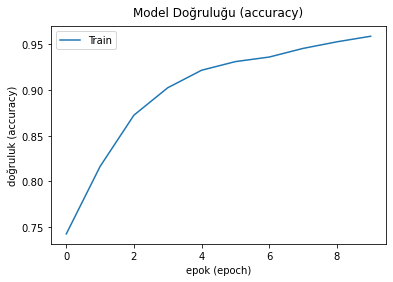

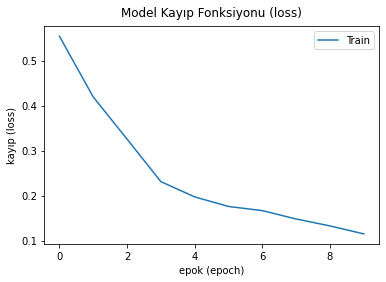

In [60]:
# doğruluk (accuracy) grafiği
plt.plot(history.history['accuracy'])
plt.title('Model Doğruluğu (accuracy)', pad=10)
plt.ylabel('doğruluk (accuracy)')
plt.xlabel('epok (epoch)')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# kayıp (loss) fonksiyonu grafiği
plt.plot(history.history['loss'])
plt.title('Model Kayıp Fonksiyonu (loss)', pad=10)
plt.ylabel('kayıp (loss)')
plt.xlabel('epok (epoch)')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### KARIŞIKLIK MATRİSİ (CONFUSION MATRIX)

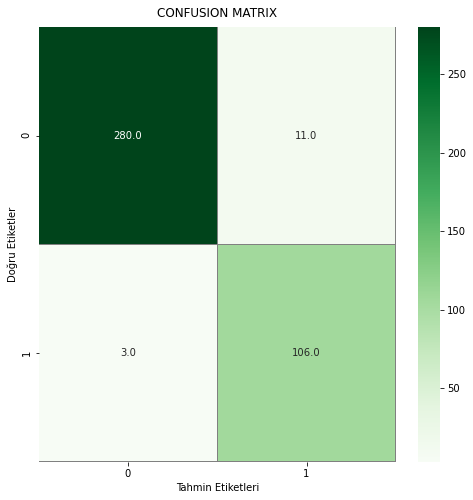

In [38]:
# Doğrulama veri kümesinden değerleri tahmin etme
Y_pred = model.predict(X_test)
# Tahmin sınıflarını tek bir vektöre dönüştürme 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Doğrulama gözlemlerini tek bir vektöre dönüştürme
Y_true = np.argmax(y_test,axis = 1) 
# karışıklık matrisini hesaplama
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# çizdirme
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Tahmin Etiketleri")
plt.ylabel("Doğru Etiketler")
plt.title("CONFUSION MATRIX", pad = 10)
plt.show()

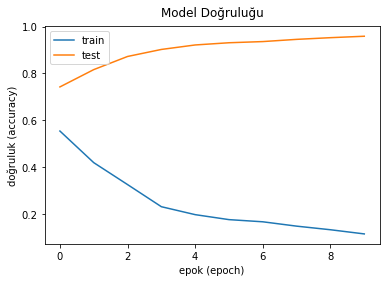

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model Doğruluğu', pad=10)
plt.ylabel('doğruluk (accuracy)')
plt.xlabel('epok (epoch)')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# model görselleştirme
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## SEÇMELİ ARAMA ALGORİTMASI

In [41]:
def find_regions(image, method):
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    
    rects = ss.process()
    boxes = []
    
    for (x,y,w,h) in rects:
        boxes.append([x,y,w,h])
        pass
    
    return boxes
    pass

### Değerlendirme Görüntülerinin Yüklenmesi

In [42]:
scene_path = 'scenes'

def load_scenes():
    
    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    for file in dirfiles:
        
        print(os.path.join(scene_path, file))
        scene = cv2.imread(os.path.join(scene_path, file))
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scenes.append(scene)
        pass
    
    return scenes
    pass

### Değerlendirme Görüntüleri

In [43]:
scenes = load_scenes()

scenes\lb_1.png
scenes\lb_2.png
scenes\lb_3.png
scenes\lb_4.png
scenes\sfbay_1.png
scenes\sfbay_2.png
scenes\sfbay_3.png
scenes\sfbay_4.png


In [48]:
%%time
method = "fast"
boxes = []
for scene in scenes:
    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

Wall time: 17min 6s


In [49]:
# model yükleme
model = load_model('cnn_model.h5')

## BOUNDING BOX VE TAHMİN

In [50]:
%%time

rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):
    
    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        if w/float(W) > 0.10 and h/float(H) > 0.10:
            continue

        roi = scene[y:y+h,x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (80,80))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass
    
    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)
    
    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass
    
    images.append(img)
    del rois[:]
    del locs[:]
    pass

8it [15:11, 113.88s/it]


Wall time: 15min 23s
Parser   : 156 ms


## DEĞERLENDİRME GÖRÜNTÜLERİ

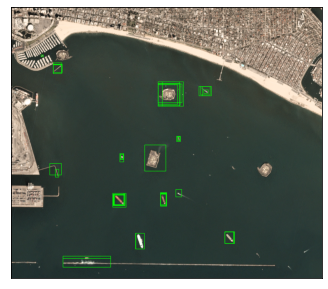

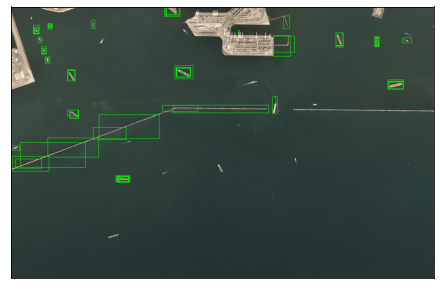

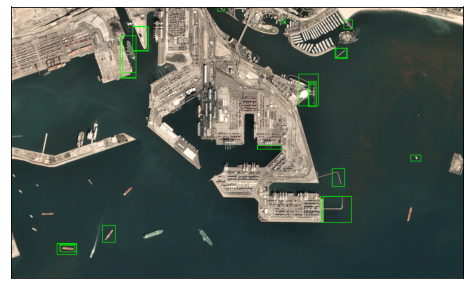

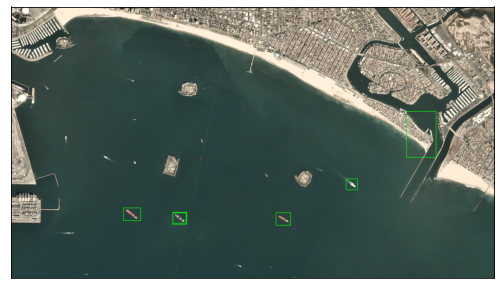

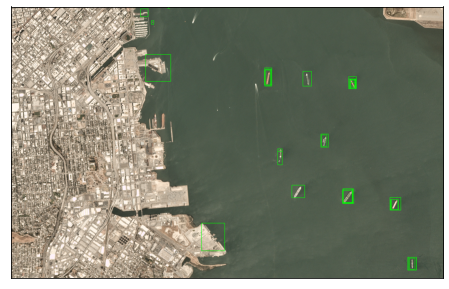

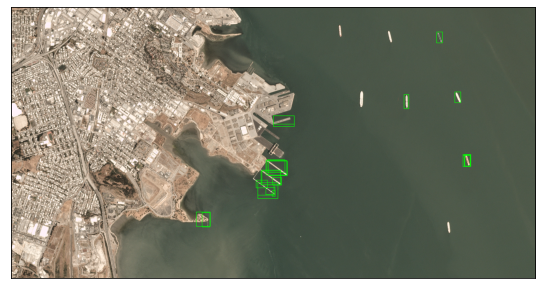

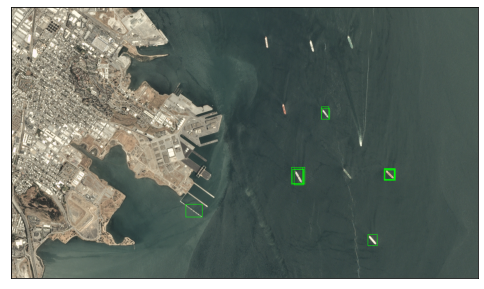

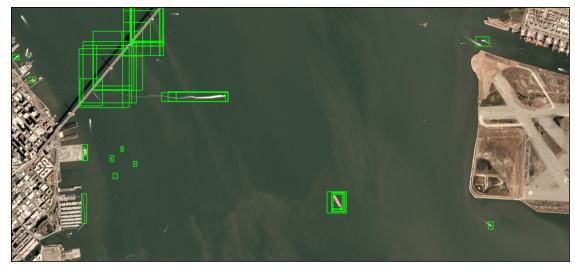

In [51]:
for image in images:
    plt.figure(figsize=(10,5))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show();